# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter. 

In [3]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/assignment3"
if not os.path.exists(datadir):
  !ln -s "/content/drive/My Drive/CS444/assignment3/" $datadir # TODO: Fill your A3 path
os.chdir(datadir)
!pwd

/content/drive/My Drive/CS444/assignment3


#Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random


def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    # TODO: Implement rotate_img() - return the rotated img
    elif rot == 1:
      return transforms.functional.rotate(img, -90)
    elif rot == 2:
      return transforms.functional.rotate(img, -180)
    elif rot == 3:
      return transforms.functional.rotate(img, -270)
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')


class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [6]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Show some example images and rotated images with labels:

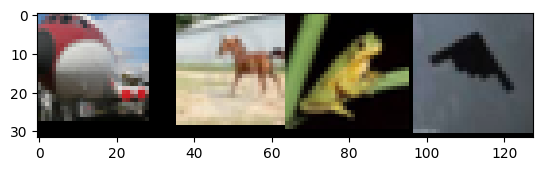

Class labels:  plane horse frog  plane


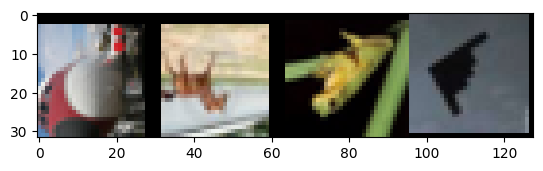

Rotation labels:  270   180   180   270  


In [7]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

#Evaluation code

In [8]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [9]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#Train a ResNet18 on the rotation task

In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [12]:
import torch.optim as optim

# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 1e-2, momentum=0.9)

In [13]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            #
            if task == 'rotation':
              inputs = imgs_rotated.to(device)
              labels = rotation_label.to(device)
            elif task == 'classification':
              inputs = imgs.to(device)
              labels = cls_label.to(device)

            # Zero the parameter gradients
            #
            optimizer.zero_grad()

            # TODO: forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


            # TODO: Get predicted results
            _, predicted = torch.max(outputs.data, 1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        #
        #
        net.eval()
        run_test(net, testloader, criterion, task)

    print('Finished Training')

In [68]:
train(net, criterion, optimizer, num_epochs=50, decay_epochs=12, init_lr=0.01, task='rotation')

# TODO: Save the model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

[1,   100] loss: 0.720 acc: 71.22 time: 4.94
[1,   200] loss: 0.727 acc: 70.47 time: 5.03
[1,   300] loss: 0.735 acc: 70.62 time: 4.56
TESTING:
Accuracy of the network on the 10000 test images: 71.67 %
Average loss on the 10000 test images: 0.708
[2,   100] loss: 0.722 acc: 71.09 time: 4.71
[2,   200] loss: 0.737 acc: 70.59 time: 4.52
[2,   300] loss: 0.729 acc: 70.88 time: 5.10
TESTING:
Accuracy of the network on the 10000 test images: 71.38 %
Average loss on the 10000 test images: 0.713
[3,   100] loss: 0.718 acc: 71.05 time: 5.29
[3,   200] loss: 0.728 acc: 70.66 time: 4.91
[3,   300] loss: 0.723 acc: 71.24 time: 4.54
TESTING:
Accuracy of the network on the 10000 test images: 72.04 %
Average loss on the 10000 test images: 0.708
[4,   100] loss: 0.713 acc: 71.36 time: 4.77
[4,   200] loss: 0.706 acc: 72.27 time: 5.21
[4,   300] loss: 0.712 acc: 71.48 time: 4.56
TESTING:
Accuracy of the network on the 10000 test images: 72.07 %
Average loss on the 10000 test images: 0.696
[5,   100] l

##Fine-tuning on the pre-trained model

In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [14]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
net = resnet18(pretrained=True)
net = net.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [15]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
for name, param in net.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [16]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [17]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001, momentum=0.9)

In [73]:
train(net, criterion, optimizer, num_epochs=40, decay_epochs=10, init_lr=0.01, task='classification')


[1,   100] loss: 2.193 acc: 36.12 time: 4.81
[1,   200] loss: 1.408 acc: 50.95 time: 4.94
[1,   300] loss: 1.275 acc: 55.55 time: 4.38
TESTING:
Accuracy of the network on the 10000 test images: 57.41 %
Average loss on the 10000 test images: 1.497
[2,   100] loss: 1.179 acc: 59.38 time: 4.49
[2,   200] loss: 1.130 acc: 60.79 time: 4.35
[2,   300] loss: 1.121 acc: 60.90 time: 5.04
TESTING:
Accuracy of the network on the 10000 test images: 61.95 %
Average loss on the 10000 test images: 1.148
[3,   100] loss: 1.083 acc: 63.37 time: 4.96
[3,   200] loss: 1.045 acc: 64.16 time: 4.37
[3,   300] loss: 1.053 acc: 63.17 time: 4.32
TESTING:
Accuracy of the network on the 10000 test images: 65.94 %
Average loss on the 10000 test images: 1.004
[4,   100] loss: 1.000 acc: 64.90 time: 4.52
[4,   200] loss: 1.004 acc: 65.47 time: 4.67
[4,   300] loss: 1.003 acc: 64.82 time: 4.67
TESTING:
Accuracy of the network on the 10000 test images: 62.91 %
Average loss on the 10000 test images: 1.543
[5,   100] l

## Fine-tuning on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [18]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
# Define ResNet18 model
model = resnet18()
for param in model.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

In [19]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# To do this, you should set requires_grad=False for the frozen layers.
for name, param in net.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [20]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [21]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001, momentum=0.9)

In [22]:
train(net, criterion, optimizer, num_epochs=30, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.180 acc: 37.37 time: 10.33
[1,   200] loss: 1.392 acc: 50.99 time: 4.65
[1,   300] loss: 1.292 acc: 55.48 time: 5.15
TESTING:
Accuracy of the network on the 10000 test images: 59.53 %
Average loss on the 10000 test images: 1.196
[2,   100] loss: 1.170 acc: 59.45 time: 5.11
[2,   200] loss: 1.138 acc: 60.80 time: 4.28
[2,   300] loss: 1.127 acc: 60.50 time: 4.27
TESTING:
Accuracy of the network on the 10000 test images: 60.92 %
Average loss on the 10000 test images: 1.487
[3,   100] loss: 1.056 acc: 62.96 time: 4.52
[3,   200] loss: 1.072 acc: 63.15 time: 4.99
[3,   300] loss: 1.032 acc: 64.05 time: 4.57
TESTING:
Accuracy of the network on the 10000 test images: 61.77 %
Average loss on the 10000 test images: 1.454
[4,   100] loss: 0.993 acc: 65.59 time: 5.19
[4,   200] loss: 1.004 acc: 64.59 time: 4.35
[4,   300] loss: 0.988 acc: 65.12 time: 4.82
TESTING:
Accuracy of the network on the 10000 test images: 65.43 %
Average loss on the 10000 test images: 1.027
[5,   100] 

##Supervised training on the pre-trained model
In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [23]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
net = resnet18(pretrained=True)
net = net.to(device)

In [24]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.01, momentum=0.9)

In [25]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.215 acc: 30.13 time: 5.50
[1,   200] loss: 1.381 acc: 49.93 time: 4.43
[1,   300] loss: 1.150 acc: 59.52 time: 4.44
TESTING:
Accuracy of the network on the 10000 test images: 67.89 %
Average loss on the 10000 test images: 0.963
[2,   100] loss: 0.913 acc: 68.55 time: 4.62
[2,   200] loss: 0.878 acc: 70.19 time: 4.96
[2,   300] loss: 0.810 acc: 72.10 time: 4.57
TESTING:
Accuracy of the network on the 10000 test images: 74.56 %
Average loss on the 10000 test images: 0.740
[3,   100] loss: 0.730 acc: 75.04 time: 5.09
[3,   200] loss: 0.672 acc: 76.97 time: 4.50
[3,   300] loss: 0.697 acc: 76.25 time: 4.92
TESTING:
Accuracy of the network on the 10000 test images: 76.84 %
Average loss on the 10000 test images: 0.699
[4,   100] loss: 0.626 acc: 78.66 time: 4.79
[4,   200] loss: 0.612 acc: 78.88 time: 4.93
[4,   300] loss: 0.623 acc: 78.65 time: 4.52
TESTING:
Accuracy of the network on the 10000 test images: 79.54 %
Average loss on the 10000 test images: 0.599
[5,   100] l

##Supervised training on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [26]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
model = resnet18()
for param in model.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

In [27]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.01, momentum=0.9)

In [28]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 0.356 acc: 87.91 time: 5.06
[1,   200] loss: 0.387 acc: 86.14 time: 4.42
[1,   300] loss: 0.385 acc: 86.72 time: 4.59
TESTING:
Accuracy of the network on the 10000 test images: 83.53 %
Average loss on the 10000 test images: 0.499
[2,   100] loss: 0.388 acc: 86.57 time: 4.62
[2,   200] loss: 0.388 acc: 86.51 time: 4.84
[2,   300] loss: 0.387 acc: 86.30 time: 4.51
TESTING:
Accuracy of the network on the 10000 test images: 83.89 %
Average loss on the 10000 test images: 0.479
[3,   100] loss: 0.347 acc: 87.95 time: 4.90
[3,   200] loss: 0.369 acc: 87.01 time: 4.34
[3,   300] loss: 0.378 acc: 86.70 time: 4.64
TESTING:
Accuracy of the network on the 10000 test images: 84.63 %
Average loss on the 10000 test images: 0.476
[4,   100] loss: 0.348 acc: 87.99 time: 4.69
[4,   200] loss: 0.361 acc: 87.41 time: 4.92
[4,   300] loss: 0.352 acc: 87.98 time: 4.32
TESTING:
Accuracy of the network on the 10000 test images: 83.65 %
Average loss on the 10000 test images: 0.503
[5,   100] l